<a href="https://colab.research.google.com/github/wdoppenberg/cs4240-project/blob/master/ArtClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Transfer Learning for Art Classification Problems - A Reproduction Study

By [Jasper Veen](https://www.linkedin.com/in/jasper-veen), [Bruno Martens](https://www.linkedin.com/in/brunomartens), [Max Hermans](https://www.linkedin.com/in/max-hermans-8324b0b1), and [Wouter Doppenberg](https://www.linkedin.com/in/wouterdoppenberg)

Delft University of Technology, the Netherlands
<br></br>

---




Original Paper by: Matthia Sabatelli, Mike Kestemont, Walter Daelemans, and Pierre Geurts

Université de Liège, Belgium

Universiteit Antwerpen, Belgium

[Original study's repository](https://github.com/paintception/Deep-Transfer-Learning-for-Art-Classification-Problems)

[Original paper](https://www.researchgate.net/publication/327498843_Deep_Transfer_Learning_for_Art_Classification_Problems)

## Setup

[DOWNLOAD DATASET](https://drive.google.com/open?id=1-nOa-93oohjw2mm6taBb1Y4TpXIDgSID)

Add these to your Google Drive in order to work with them through Colab. Make sure that you change directory accordingly. 

Make sure you activate the GPU runtime under `Runtime` > `Change runtime type`. If you happen to have a CUDA-enabled GPU locally, it might be more worthwhile to download the dataset and run this notebook through JupyterLab.

Adjust the variables to adjust the notebook to the desired experiment type, and make sure to *run* the following cell before continuing. 

In [0]:
#@markdown Path of workspace folder relative from Google Drive root you wish to execute this notebook from, also serves as root folder for `CHECKPOINT_ROOT` and `DATASETS_PATH`.
WORKSPACE_PATH = 'Colab Notebooks/cs4240-project' #@param {type:'string'}
#@markdown Define whether to use pretrained weights (ImageNet).
PRETRAINED_ON_IMAGENET = False #@param ['True', 'False'] {type:'raw'}
#@markdown Base path to store the model checkpoint files.
CHECKPOINT_ROOT = 'models/PyTorch/' #@param {type:'string'}
#@markdown Base path pointing to the dataset files. Expecting HDF5 files, split into `training.hdf5`, `validation.hdf5`, and `testing.hdf5` or similar.
DATASETS_PATH = 'datasets/Backup_Data/' #@param {type:'string'}
#@markdown Model type name.
MODEL = 'VGG19' #@param ['VGG19', 'ResNet50', 'EfficientNet'] {type:'string'}
#@markdown The challenge to attempt. All challenges as described in the paper have been implemented, which refer to type and creator classification, respectively.
CHALLENGE = 'creator' #@param ['material', 'type', 'creator'] {type:'string'}
#@markdown How many epochs to train for.
EPOCHS_PER_SESSION = 5 #@param {type: "slider", min: 1, max: 20}

WORKSPACE_PATH = '/content/drive/My Drive/'+WORKSPACE_PATH

CHECKPOINT_PATH = CHECKPOINT_ROOT + CHALLENGE + '/'
training_type = 'FineTuning' if PRETRAINED_ON_IMAGENET else 'OffTheShelf'
EXPERIMENT_NAME = f'{MODEL}_{training_type}_Rijks_{CHALLENGE}'
print(
    f'Running experiment with the following name: {EXPERIMENT_NAME}\n'
    f'Using training.hdf5, validation.hdf5, and testing.hdf5 from {DATASETS_PATH}\n'
    f'Saving checkpoint files under {CHECKPOINT_PATH}\n'
    f'Training for {EPOCHS_PER_SESSION} epochs'
)

Running experiment with the following name: VGG19_OffTheShelf_Rijks_creator
Using training.hdf5, validation.hdf5, and testing.hdf5 from datasets/Backup_Data/
Saving checkpoint files under models/PyTorch/creator/
Training for 5 epochs


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd $WORKSPACE_PATH

/content/drive/My Drive/Colab Notebooks/cs4240-project


In [0]:
pip install -q -r requirements.txt

     |████████████████████████████████| 7.8MB 3.0MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
from pathlib import Path
import random
import time

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.optim import SGD
import h5py

## Create DataLoaders

In order to train or evaluate the networks, `DataLoader` instances needed to be custom-made for the acquired dataset. This meant first creating a custom `HDF5Dataset` with `Dataset` as a base class. This allowed for easy minibatch generation in a training or evaluation loop. 

The necessary transformations on the data are implemented at this phase too, resizing and normalizing the images. 

In [0]:
# Test dataset
i = 1234
with h5py.File(DATASETS_PATH+'training.hdf5', 'r') as f:
    print(f['fullname_creator'][i], f['material'][i], f['type'][i])
    img = Image.open(
        io.BytesIO(f['images'][i])
        ).convert('RGB')
img

In [0]:
train_path = DATASETS_PATH+'training.hdf5'
test_path = DATASETS_PATH+'testing.hdf5'
val_path = DATASETS_PATH+'validation.hdf5'

input_size = 224
batch_size = 32

labels = {
    'material':'material_cat',
    'type':'type_cat',
    'creator':'fullname_creator_cat'
}

classes = {
    'material':128,
    'type':534,
    'creator':6620
}

num_classes = classes[CHALLENGE]

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalize = UnNormalize(norm_mean, norm_std)

TensorToImage = transforms.ToPILImage(mode='RGB')

class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, path, challenge):
        self.f = h5py.File(path, 'r')

        self.n_images = len(self.f['images'])
        self.challenge = challenge

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (
            transform(
                Image.open(
                    io.BytesIO(self.f['images'][idx])
                ).convert('RGB')
            ),
            int(self.f[self.challenge][idx])
        )
    
    def random(self):
        return self.__getitem__(
            random.randint(0, self.n_images)
        )

    def __len__(self):
        return self.n_images

    def __del__(self):
        self.f.close()

train_dataset = HDF5Dataset(train_path, labels[CHALLENGE])
test_dataset = HDF5Dataset(test_path, labels[CHALLENGE])
validation_dataset = HDF5Dataset(val_path, labels[CHALLENGE])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=1, 
                                        shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                        batch_size=batch_size, 
                                        shuffle=True) 

## Create or load model

The following cell creates or loads the PyTorch model state dependent on the experiment setup. If a checkpoint file associated with the `EXPERIMENT_NAME` exists, it will automatically load that file for further use. 

Besides loading model state, this cell also loads the optimizer state, as well as the average loss per epoch of previous training sessions.

`nn.CrossEntropyLoss()` is used as a loss function, just as the original project. 

In [0]:
def get_model(name, pretrained, nc):
    if name == 'VGG19':
        model = models.vgg19(pretrained=pretrained)
        model.classifier[6] = nn.Linear(4096, nc)
        return model

    elif name == 'ResNet50':
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(2048, nc)
        return model

    elif name == 'EfficientNet':
        if pretrained:
            model = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            model = EfficientNet.from_name('efficientnet-b7')
        model._fc = nn.Linear(2560, nc)
        return model
    else:
        print(f'Model called {name} not found...')

In [0]:
checkpoint_path_full = CHECKPOINT_PATH+EXPERIMENT_NAME+'.pth'

loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
momentum = 0.9

if Path(checkpoint_path_full).is_file():
    print('Using checkpoint file...')
    if ~torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path_full, map_location=torch.device('cpu'))
    else:    
        checkpoint = torch.load(checkpoint_path_full)

    model = get_model(MODEL, False, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Activate the GPU in the Colab runtime settings to utilize cuda acceleration
    if torch.cuda.is_available():
        model.cuda()
        loss_function.cuda()
        print(f'Using GPU: {torch.cuda.get_device_name(0)}')
    else:
        print('Using CPU')

    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    avg_train_losses = checkpoint['avg_train_losses']
    avg_val_losses = checkpoint['avg_val_losses']
    accuracy = checkpoint['accuracy']

else:
    print(f'No checkpoint file named {EXPERIMENT_NAME}.pth found; Creating new model...')
    model = get_model(MODEL, PRETRAINED_ON_IMAGENET, num_classes)

    if torch.cuda.is_available():
        model.cuda()
        loss_function.cuda()
        print(f'Using GPU: {torch.cuda.get_device_name(0)}')
    else:
        print('Using CPU')

    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    epoch = 0
    avg_train_losses, avg_val_losses = [], []
    accuracy = []

Using checkpoint file...
Using CPU


## Train model

Executing the following cell will train the model using an editable checkpoint strategy (to prevent one from losing all training progress). 

Be aware that if the previous cell did not state that a *GPU* will be used, it is a very slow process, and will probably not be realistic to train to any satisfactory degree. 

The loss values are recorded in the checkpoint files, however be aware that these are the average loss values per epoch. This means that especially in the first few epochs the training loss may appear higher, but this is caused by the fact that the validation error is determined at the end of a training epoch, meaning on average the loss would be lower if the loss gradient is still relatively steep. 

In [0]:
epoch_list = range(epoch+1, epoch + (EPOCHS_PER_SESSION) + 1)

for e in epoch_list:
    print(f'\n-----Epoch {e} started.-----\n')

    since = time.time()
    
    train_losses, val_losses = [], []

    model.train()
    for batch, (images, labels) in enumerate(train_loader, 1):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        logits = model(images)

        loss = loss_function(logits, labels)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if batch % 200 == 0 or batch == 1 or batch==len(train_loader):
            time_elapsed = time.time() - since
            print(
                f'Training loss = {np.average(train_losses):8.3f} | ',
                f'Batch # {batch:6.0f} | [{time_elapsed//60:3.0f}m {time_elapsed%60:2.0f}s]')
        
    model.eval()
    score = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            logits = model(images)
            val_losses.append(loss_function(logits, labels).item())

            top_p, top_class = logits.topk(1, dim=1)
            correct = top_class.squeeze() == labels
            score += torch.sum(correct.float())

    # Save epoch stats
    avg_train_losses.append(np.average(train_losses))
    avg_val_losses.append(np.average(val_losses))
    accuracy.append(score/len(validation_dataset))

    time_elapsed = time.time() - since
    print(
        f"\nSummary:\n",
        f"\tEpoch: {e}/{epoch_list[-1]}\n",
        f"\tLearning Rate: {learning_rate}\n",
        f"\tTraining Loss: {avg_train_losses[-1]:.5f}\n",
        f"\tValidation Loss: {avg_val_losses[-1]:.5f}\n",
        f"\tAccuracy: {accuracy[-1]*100:.2f}%\n",
        f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
    )
    
    print(f'-----Epoch {e} finished.-----\n')

    print(f'Saving model as {checkpoint_path_full} at epoch #{e}')
    torch.save(
        {
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_train_losses': avg_train_losses,
            'avg_val_losses': avg_val_losses,
            'accuracy': accuracy
        }, 
        checkpoint_path_full
    )

# Ensuring multiple runs of this cell stack up
epoch = e

## Evaluate model with test data

The following cell calculates the accuracy over the testing dataset. 

In [0]:
# Test accuracy

score = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        logits = model(images)

        top_p, top_class = logits.topk(1, dim=1)
        correct = top_class.squeeze() == labels
        score += torch.sum(correct.float())

test_accuracy = score/len(test_dataset)

print(
    f"Test summary:\n",
    f"\tEpochs: {e}\n",
    f"\tScore: {score:.0f}/{len(test_dataset)} correct inferences\n",
    f"\tTesting accuracy: {test_accuracy*100:.2f}%"
)

Test summary:
 	Epochs: 2
 	Score: 3536/3787 correct inferences
 	Testing accuracy: 93.37%


## Plot training vs. validation loss

This cell plots the training and validation loss over the epochs. Once again, these are average loss values over epochs.

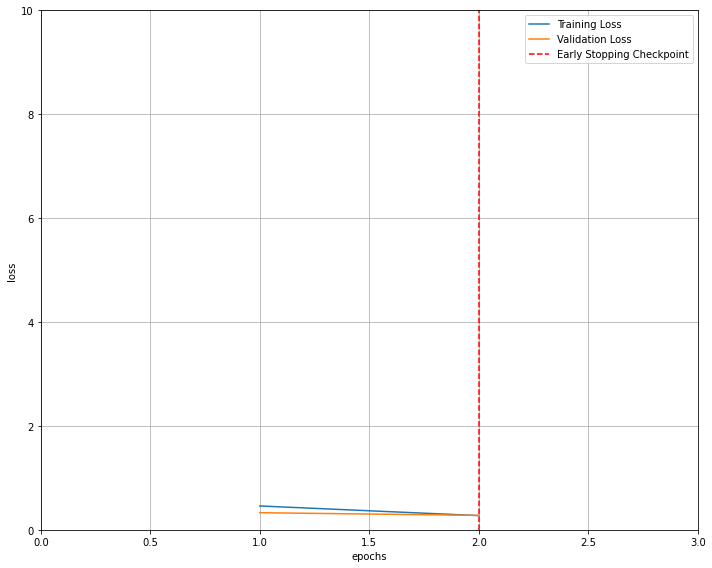

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_train_losses)+1), avg_val_losses, label='Validation Loss')

#find position of lowest validation loss
minposs = avg_val_losses.index(min(avg_val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 10) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Test model

In [0]:
import pandas as pd

metadata = pd.read_csv(DATASETS_PATH+'metadata_rijks_enc.csv')

df_material = metadata[['material', 'material_cat']].copy()
df_material.drop_duplicates(inplace=True)
df_material.columns = ['string', 'label']

df_type = metadata[['type', 'type_cat']].copy()
df_type.drop_duplicates(inplace=True)
df_type.columns = ['string', 'label']

df_creator = metadata[['fullname_creator', 'fullname_creator_cat']].copy()
df_creator.drop_duplicates(inplace=True)
df_creator.columns = ['string', 'label']

dict_labels = dict(material=df_material, type=df_type, creator=df_creator)

Ground truth: [341] prent
Prediction: [341] prent
Correct!


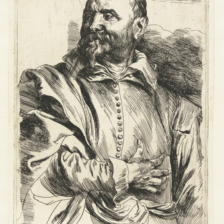

In [0]:
image, label = next(iter(test_loader))
if torch.cuda.is_available():
    image, label = image.cuda(), label.cuda()
model.eval()

logits = model(image)
ground_truth = label.item()
prediction = logits.argmax(dim=1).item() 

df = dict_labels[CHALLENGE]
gt_string = df[df['label']==ground_truth]['string'].item()
pred_string = df[df['label']==prediction]['string'].item()
corr = 'Correct!' if prediction==ground_truth else 'Incorrect.'
print(
    f'Ground truth: [{ground_truth}] {gt_string}\n'
    f'Prediction: [{prediction}] {pred_string}\n'+
    corr
)
TensorToImage(unnormalize(image[0].cpu()))

tensor([341])


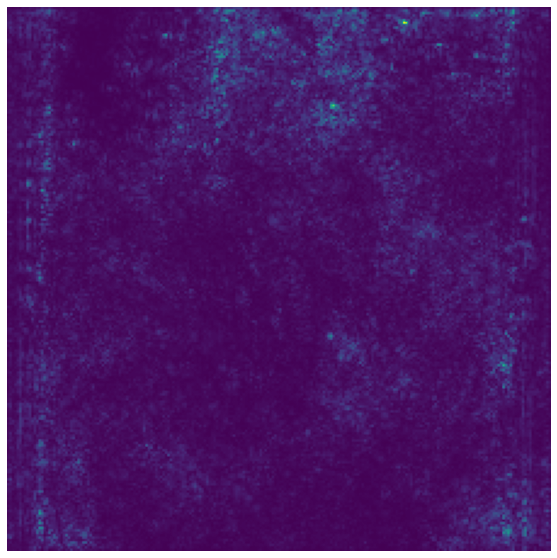

In [0]:
# Saliency maps
image, label = next(iter(test_loader))
if torch.cuda.is_available():
    image, label = image.cuda(), label.cuda()
model.eval()

image.requires_grad_()

logits = model(image)
#loss = loss_function(logits, label.argmax(dim=1))
print(logits.argmax(dim=1))

score_max_index = logits.argmax(dim=1)
score_max = logits[0, score_max_index]

score_max.backward()

saliency, _ = torch.max(image.grad.data.abs(), dim=1)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(saliency[0])
plt.axis('off')
plt.show()

Interesting sample: #12334